## Example 2: Challenges in Identifiability

Here we will explore a case where the system 

In [1]:
import sys
import os

# Add repo root to Python path (one level up from examples/)
sys.path.append(os.path.abspath(".."))  

from src.parsing import *
from src.inference import *
from src.mcmc import *
from CRN_Simulation.CRN import CRN

import numpy as np
import random

In [2]:
# Determine Stochiometric, Reactant and names of reactions
species_names = ["X1", "X2"]

# Define complexes (example: bi-molecular)
complexes = np.array([[0, 0, 0, 1, 1, 2],
                      [0, 1, 2, 0, 1, 0]])

# Create Reactant, Product, Stochiometric Matrix, Define Compatible Reactions and Everything Needed for CRN
reactant_matrix, product_matrix, stoichiometric_matrix, reaction_names, parameter_names, compatible_reactions = generate_reactions(complexes, species_names)

# Plot some output to the screen
print(f"Total reactions generated: {len(reaction_names)}")
max_show = 3
print("Some Reaction Names:", reaction_names[:max_show])

print("Some Non-Unique Stoichiometric Changes")
count_shown = 0
for deltaX, rxn_indices in compatible_reactions.items():
    if len(rxn_indices) > 1:
        deltaX_clean = tuple(int(x) for x in deltaX)
        # Grab all reaction names
        rxn_names = [reaction_names[i] for i in rxn_indices]
        print(f"ΔX = {deltaX_clean} → indices: {rxn_indices}, reactions: {rxn_names}")
        count_shown += 1
        if count_shown >= max_show:
            break

Total reactions generated: 30
Some Reaction Names: ['Empty_to_X2:', 'Empty_to_2X2:', 'Empty_to_X1:']
Some Non-Unique Stoichiometric Changes
ΔX = (0, 1) → indices: [0, 6, 18], reactions: ['Empty_to_X2:', 'X2_to_2X2:', 'X1_to_X1+X2:']
ΔX = (1, 0) → indices: [2, 8, 19], reactions: ['Empty_to_X1:', 'X2_to_X1+X2:', 'X1_to_2X1:']
ΔX = (0, -1) → indices: [5, 11, 23], reactions: ['X2_to_Empty:', '2X2_to_X2:', 'X1+X2_to_X1:']


In [3]:
##########################
# Set up Reaction System #
##########################

selected_rxns  = ["Empty_to_X1", "X1_to_2X1","X1+X2_to_X2"]
selected_rates = [1.0, 1.0,0.1]  # "Empty_to_X1", "X1_to_2X1","X2+X1_to_X2"

(CRN_stoichiometric_matrix,
 CRN_reaction_names,
 CRN_parameter_names,
 CRN_propensities,
 trueTheta,
 CRN_parameter_values,
 CRN_indices) = build_CRN_byNameSelection(
    reactant_matrix,
    product_matrix,
    stoichiometric_matrix,
    reaction_names,
    parameter_names,
    species_names,
    selected_names=selected_rxns,
    rates=selected_rates,
    verbose=True   
)


rn = CRN(
    species_names=species_names,
    stoichiometric_matrix=CRN_stoichiometric_matrix,
    parameters_names=CRN_parameter_names,
    reaction_names=CRN_reaction_names,
    propensities=CRN_propensities
)


Selected CRN Reactions:
Index  Parameter Reaction Name                  Value     
------------------------------------------------------------
2      k2       Empty_to_X1:                   1.0000    
19     k19      X1_to_2X1:                     1.0000    
21     k21      X1+X2_to_X2:                   0.1000    

Full trueTheta vector: [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  1.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0. ]



Initial state: {'X1': 0, 'X2': 5}
Trajectory saved to ../data/example2_trajectory.json
CRN trajectory saved to ../data/example2_trajectory.json


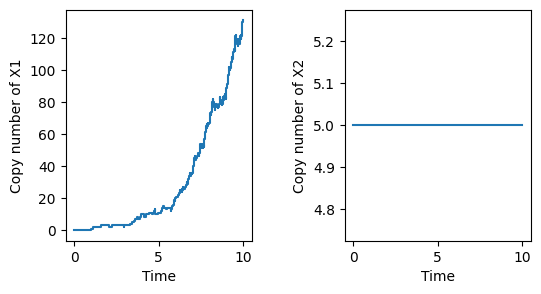

In [4]:
data_dir = "../data"  # relative to examples/ folder
os.makedirs(data_dir, exist_ok=True)

###############################
# Generate trajectory for CRN #
###############################
# Example: 2D species, X1 starts at 0, X2 starts at 10
species_min = [0, 5]
species_max = [0, 5]

time_list, state_list = generate_single_trajectory(
    rn,
    CRN_parameter_values,
    species_names,
    finalTime=10,   # adjust as needed
    minVal=species_min,
    maxVal=species_max,
    seed=42          # for reproducibility
)

trajectory_file = os.path.join(data_dir, "example2_trajectory.json")
save_trajectory(time_list, state_list, filename=trajectory_file)
print(f"CRN trajectory saved to {trajectory_file}")

In [5]:
# Parse trajectories for CRN
print("Parsing trajectory for CRN")
unique_changes, unique_states, jump_counts, waiting_times, propensities = parse_trajectory(
    state_list, time_list, reactant_matrix, compatible_reactions,verbose=True)
print("---------")
# Print basic summary
print("Finished parsing trajectories. Summary:")
print(f"CRN: {len(unique_states)} unique states observed")

Parsing trajectory for CRN
Tracking 18 unique stoichiometric changes (single trajectory).
Trajectory length: 425 timepoints.  Will iterate to len-2 to avoid final non-jump.
Finished parsing single trajectory. Observed 132 unique states.
---------
Finished parsing trajectories. Summary:
CRN: 132 unique states observed


Extracting local data for stoichiometric change [1, 0] at index 2
✅ All states processed successfully — no empty propensities, consistent lengths, no negative counts, all waiting times valid.
Local data extraction complete. 132 states processed.
Total observed jumps for this local stoichiometric change: 277
Local True Theta = [1. 0. 1.]
Log-Likelihood at True Theta = 914.8116292276268
Maximum Log-Likelihood = 926.849119029001
Best Multiplier = 1.3571428571428572
Best Theta = [1.35714286 0.         1.35714286]


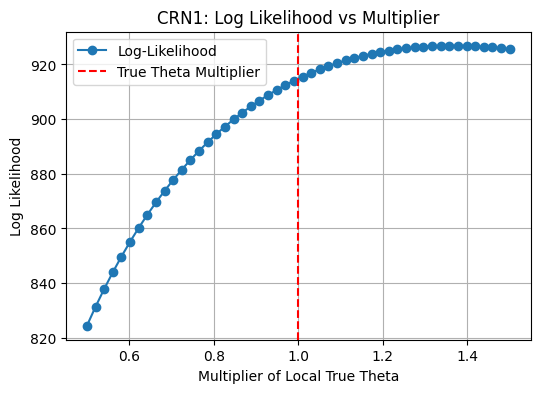

In [6]:
# Local Likelihood Exploration for the CRN

pos_indices, pos_deltaX = get_positive_deltaX_indices_and_values(jump_counts, unique_changes)

indexToCheck = pos_indices[0]
deltaXToCheck = pos_deltaX[0]

#Extract the local data for the desired stochiometric change.
(local_counts, local_waiting_times, local_propensities, selected_deltaX) = extract_local_data(
    jump_counts, waiting_times, propensities, unique_changes, 
    index=indexToCheck, deltaX=deltaXToCheck, verbose=True)

#Extract the Local True Theta for the unique stochiometric change
localTheta = trueTheta[compatible_reactions[selected_deltaX]]

multipliers, ll_values, max_ll, best_multiplier, best_theta = plot_likelihood_vs_theta_multiplier(
    local_counts,
    local_waiting_times,
    local_propensities,
    localTheta,
    delta=0.5,
    num_points=50,
    title='CRN1: Log Likelihood vs Multiplier'
)

In [9]:
# Ensure the results directory exists
results_dir = "../results/example2"
os.makedirs(results_dir, exist_ok=True)

## Debugging Parameters
runOnlyHigherDim        = False   # Only try to run cases that have >=2 variables
runOnlyOneHigherDimCase = False  # Only run one case with >=2 variables for debugging

## MCMC parameters
NIterates = 500_000
Burnin    = 50_000
Thinout   = 100

# Loop over all unique stoichiometric changes
for index, deltaX in enumerate(unique_changes):
    
    print(f"\nProcessing Index: {index}, Stoichiometric Change: {deltaX}")

    # Extract local data for this stoichiometric change
    (local_counts, local_waiting_times, local_propensities, selected_deltaX) = extract_local_data(
        jump_counts, waiting_times, propensities, unique_changes, 
        index=index, deltaX=deltaX, verbose=True
    )

    # Extract local true theta
    localTheta = trueTheta[compatible_reactions[selected_deltaX]]
    num_reactions = len(localTheta)

    # Skip low-dimensional cases if debugging
    if num_reactions < 2 and runOnlyHigherDim:
        print(f"🚫 Index {index} skipped: only {num_reactions} reaction(s) — needs at least 2 to run MCMC.")
        continue

    # Compute 2-norm
    norm_theta = np.linalg.norm(localTheta, ord=2)
    print(f"Local True Theta: {localTheta} (Norm: {norm_theta:.4f})")

    # Compute likelihood for true theta
    likeTrue = local_log_likelihood(local_counts, local_waiting_times, local_propensities, localTheta)
    print(f"True Likelihood = {likeTrue}")

    total_count = sum(local_counts.values())
    print(f"Total Count = {total_count}")

    # Initialize theta for MCMC
    a, b = 0.001, 2.0
    theta_init = np.random.uniform(a, b, size=localTheta.shape)
    likeInit = local_log_likelihood(local_counts, local_waiting_times, local_propensities, theta_init)

    # Run adaptive MCMC only if norm is significant
    if norm_theta > 0.01:
        print(f"Running Adaptive MCMC with spike-and-slab prior...")
        
        filtered_reactions = [reaction_names[i] for i in compatible_reactions[selected_deltaX]]
        print(f"Reaction Names = {filtered_reactions}")

        AdaptiveThetaChain = adaptive_mcmc_spike_slab(
            local_counts, local_waiting_times, local_propensities,
            theta_init, trueTheta, num_iterations=NIterates,
            alpha=2, beta=0.25, pi=0.75, burn_in=Burnin, adapt_every_n=10
        )

        # Define filenames
        filenameKDE = os.path.join(results_dir, f"AdaptiveMCMC_plot_Index_{index}_TotalCount_{total_count}_kde.png")
        filenameChain = os.path.join(results_dir, f"AdaptiveMCMC_plot_Index_{index}_TotalCount_{total_count}_chain.png")
        filenamePosterior = os.path.join(results_dir, f"AdaptiveMCMC_plot_Index_{index}_TotalCount_{total_count}_posterior.png")

        # Plotting
        plot_mcmc_samples(AdaptiveThetaChain, localTheta, epsilon=1e-5, burnin=Burnin, thinout=Thinout, filename=filenameKDE)
        plot_mcmc_chain(AdaptiveThetaChain, filename=filenameChain)
        if num_reactions >= 2:
            calc_network_posteriors(AdaptiveThetaChain, epsilon=1e-5, prob_cutoff=0.05, burnin=Burnin, thinout=Thinout)
            plot_network_and_parameter_posteriors(AdaptiveThetaChain, localTheta, epsilon=1e-5,
                                                 prob_cutoff=0.05, burnin=Burnin, thinout=Thinout, filename=filenamePosterior)

        # Summary statistics to Excel
        chains = [AdaptiveThetaChain]
        labels = ["Adaptive Spike & Slab"]
        summarize_chains(chains, localTheta, labels,
                         results_dir=results_dir, filename="mcmc_summary.xlsx",
                         burnin=Burnin, thinout=Thinout, alpha_ci=0.05, epsilon=1e-3,
                         run_index=index, count=total_count)

        print(f"MCMC completed for index {index}.")

        if (num_reactions > 1) and runOnlyOneHigherDimCase:
            break

    else:
        print(f"Skipping MCMC for index {index}: norm too small ({norm_theta:.4f}).")

    print("**********")



Processing Index: 0, Stoichiometric Change: (0, 1)
Extracting local data for stoichiometric change [0, 1] at index 0
✅ All states processed successfully — no empty propensities, consistent lengths, no negative counts, all waiting times valid.
Local data extraction complete. 132 states processed.
Local True Theta: [0. 0. 0.] (Norm: 0.0000)
True Likelihood = 0.0
Total Count = 0
Skipping MCMC for index 0: norm too small (0.0000).
**********

Processing Index: 1, Stoichiometric Change: (0, 2)
Extracting local data for stoichiometric change [0, 2] at index 1
✅ All states processed successfully — no empty propensities, consistent lengths, no negative counts, all waiting times valid.
Local data extraction complete. 132 states processed.
Local True Theta: [0.] (Norm: 0.0000)
True Likelihood = 0.0
Total Count = 0
Skipping MCMC for index 1: norm too small (0.0000).
**********

Processing Index: 2, Stoichiometric Change: (1, 0)
Extracting local data for stoichiometric change [1, 0] at index 2
✅ 

/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:26: RuntimeWarning: invalid value encountered in divide
  acf = acf[n-1:] / acf[n-1]
/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:35: RuntimeWarning: invalid value encountered in scalar divide
  z = (np.mean(a) - np.mean(b)) / np.sqrt(np.var(a)/len(a) + np.var(b)/len(b))
/Users/suzannesindi/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
